In [1]:
!pip install keras-tuner --quiet

In [2]:
import os
import glob
import pandas as pd
from tqdm import tqdm
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-2-ec4e967e049d>:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 3. Define dataset path
dataset_path = '/content/drive/MyDrive/Transcript'

# 4. Function to load all CSVs and assign labels
def load_dialogues(folder_path, label):
    all_data = []
    files = glob.glob(os.path.join(folder_path, "*.csv"))
    for file in tqdm(files, desc=f"Loading {os.path.basename(folder_path)}"):
        try:
            df = pd.read_csv(file)
            dialogue_text = " ".join(df.astype(str).values.flatten())
            all_data.append((dialogue_text, label))
        except Exception as e:
            print(f"Error reading {file}: {e}")
    return all_data

In [5]:
path = '/content/drive/MyDrive/Transcript'# Replace with your actual path
print("Folders inside:", os.listdir(path))

Folders inside: ['Non-Depression', 'Depression']


In [6]:
# 5. Load depression and non-depression data
depression_data = load_dialogues(os.path.join(dataset_path, 'Depression'), 1)
non_depression_data = load_dialogues(os.path.join(dataset_path, 'Non-Depression'), 0)

# Combine into a DataFrame
all_data = pd.DataFrame(depression_data + non_depression_data, columns=["text", "label"])

# Shuffle the data
all_data = all_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Preview
all_data.head()

Loading Non-Depression: 100%|██████████| 66/66 [00:00<00:00, 118.55it/s]


,text,label
0,A Okay. B So now I'm going to bring in our vir...,1
1,A I'm going to actually have you scoot up. Yea...,0
2,A I'm also gonna do something that looks even ...,1
3,"A All right, looks good. I'm going to put it r...",1
4,"A Okay, the recording's up. Now I'm going to d...",0


In [7]:
aug_df = pd.read_csv('/content/augmented_dataset.csv')
aug_df.head()

,text,label,preprocessed_text
0,A It so she's going to ask you serious questio...,1,go ask seriou question done say goodby ring do...
1,A So now I'm going to turn to the other thing....,1,go turn thing like said go ask seri question d...
2,"A Okay, good to go. Okay, so put this right he...",0,okay good go okay put right actual let move ge...
3,A I will. B So just make sure to press this bu...,1,b make sure press button press twice okay c ok...
4,"A Okay, thank you. B Hi, I'm Ellie. Thanks for...",0,okay thank b hi elli thank come today creat ta...


In [8]:
all_data.shape

(132, 2)

In [9]:
aug_df.shape

(264, 3)

In [10]:
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')  # Fast & good for Colab

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  57%|#####7    | 252M/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
def get_dialogue_embedding(text):
    sentences = sent_tokenize(text)
    embeddings = model.encode(sentences)

    mean_pool = np.mean(embeddings, axis=0)
    max_pool = np.max(embeddings, axis=0)

    combined = np.concatenate([mean_pool, max_pool])
    return combined

In [12]:
X = np.array([get_dialogue_embedding(t) for t in aug_df['text']])
y = np.array(aug_df['label'])

In [13]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))
    model.add(Dense(hp.Int('units1', 128, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(Dense(hp.Int('units2', 64, 128, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(hp.Int('units3', 32, 64, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout3', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [30]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='mlp_depression_classification'
)

tuner.search(X, y, validation_split=0.1, epochs=150, batch_size=16, verbose=1)

Reloading Tuner from tuner_results/mlp_depression_classification/tuner0.json



 Fold 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Accuracy: 0.9057
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        26
           1       0.96      0.85      0.90        27

    accuracy                           0.91        53
   macro avg       0.91      0.91      0.91        53
weighted avg       0.91      0.91      0.91        53



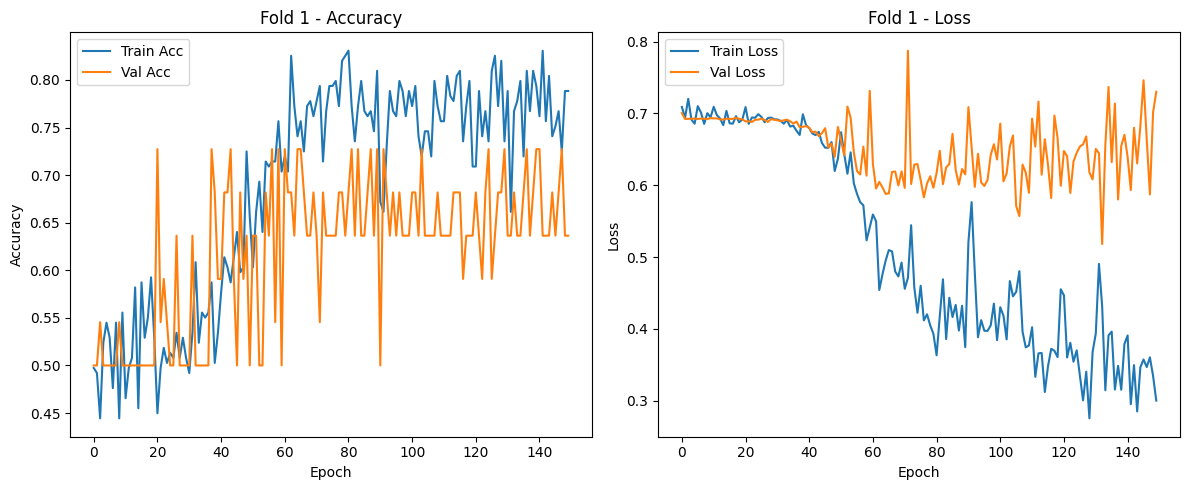


 Fold 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Accuracy: 0.8113
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        26
           1       0.87      0.74      0.80        27

    accuracy                           0.81        53
   macro avg       0.82      0.81      0.81        53
weighted avg       0.82      0.81      0.81        53



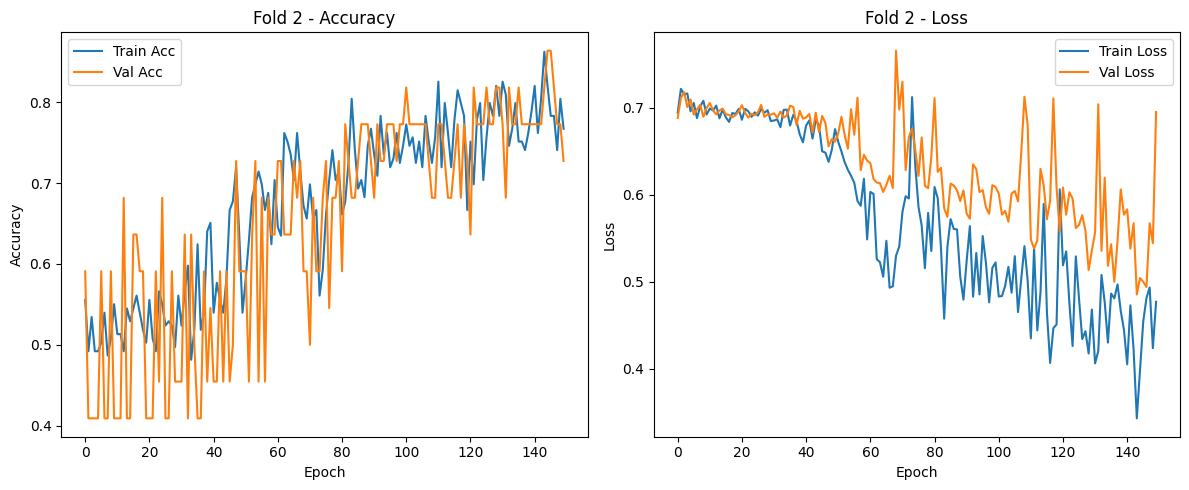


 Fold 3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Accuracy: 0.8302
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        27
           1       0.90      0.73      0.81        26

    accuracy                           0.83        53
   macro avg       0.84      0.83      0.83        53
weighted avg       0.84      0.83      0.83        53



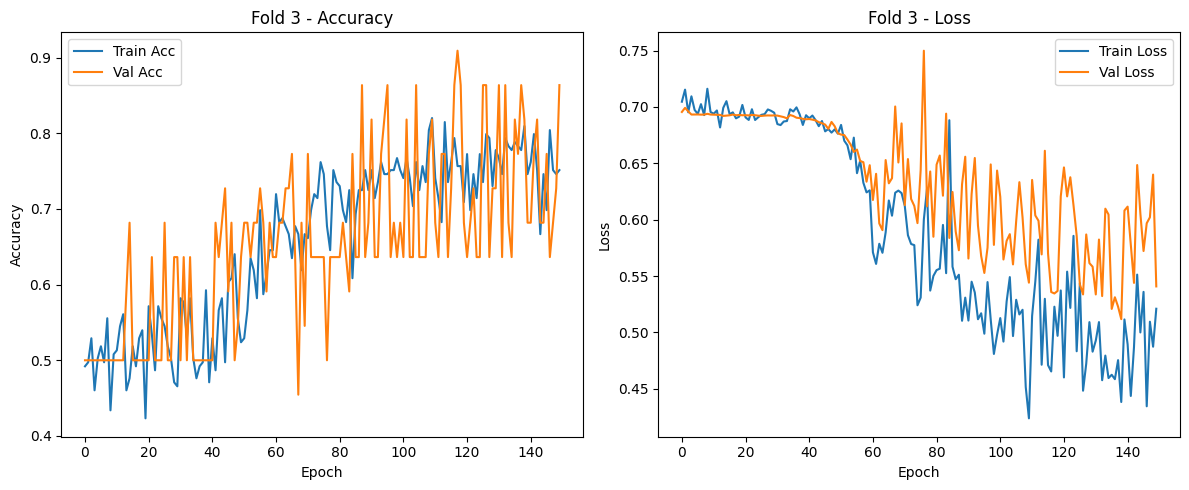


 Fold 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Accuracy: 0.8113
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        27
           1       0.86      0.73      0.79        26

    accuracy                           0.81        53
   macro avg       0.82      0.81      0.81        53
weighted avg       0.82      0.81      0.81        53



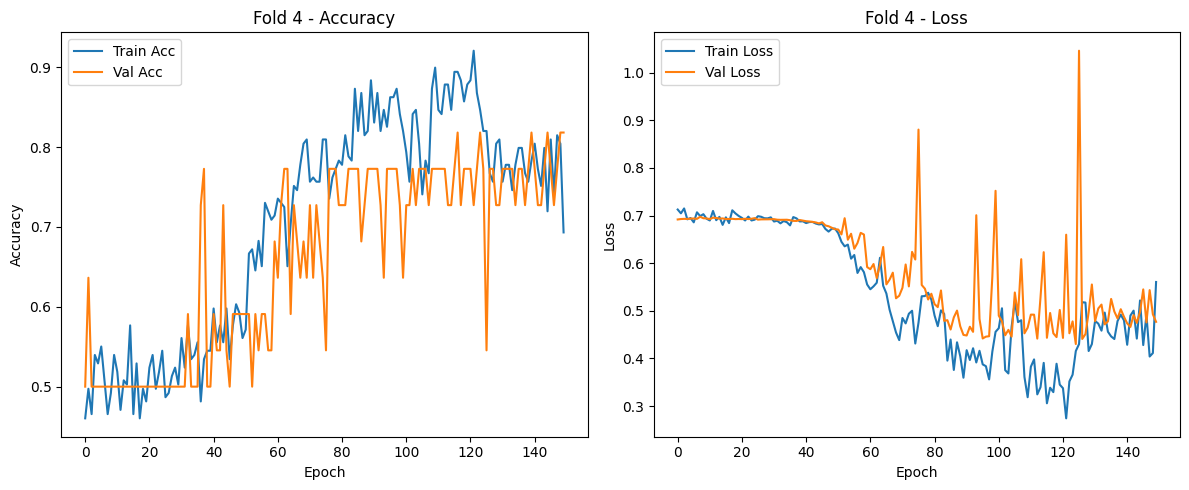


 Fold 5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Accuracy: 0.9038
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        26
           1       0.92      0.88      0.90        26

    accuracy                           0.90        52
   macro avg       0.90      0.90      0.90        52
weighted avg       0.90      0.90      0.90        52



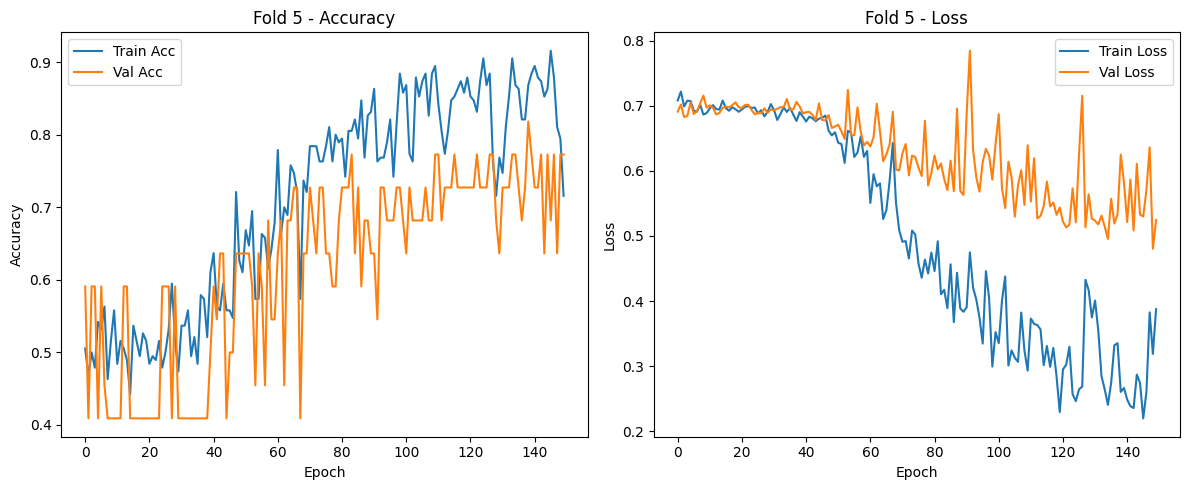

In [31]:
import matplotlib.pyplot as plt

# Get Best Hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Stratified K-Fold Evaluation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_reports = []
fold = 1

for train_idx, test_idx in kf.split(X, y):
    print(f"\n Fold {fold}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))
    model.add(Dense(best_hp['units1'], activation='relu'))
    model.add(Dropout(best_hp['dropout1']))
    model.add(Dense(best_hp['units2'], activation='relu'))
    model.add(Dropout(best_hp['dropout2']))
    model.add(Dense(best_hp['units3'], activation='relu'))
    model.add(Dropout(best_hp['dropout3']))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=best_hp['lr']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(X_train, y_train, validation_split=0.1, epochs=150, batch_size=16, verbose=0)

    y_pred_probs = model.predict(X_test).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    report = classification_report(y_test, y_pred, output_dict=True)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    if fold == 5:
        model.save("best_fold5_model.h5")

    # Plot training accuracy and loss per fold
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {fold} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    all_reports.append(report)
    fold += 1

In [32]:
# 10. Average Metrics Across Folds
report_df = pd.DataFrame([r['weighted avg'] for r in all_reports])
print("\n📊 Average Metrics Across Folds:")
print(report_df.mean())


📊 Average Metrics Across Folds:
precision     0.858910
recall        0.852467
f1-score      0.851620
support      52.800000
dtype: float64


In [33]:
report_df

,precision,recall,f1-score,support
0,0.911109,0.905660,0.905459,53.0
1,0.819087,0.811321,0.810512,53.0
2,0.841841,0.830189,0.828352,53.0
3,0.818071,0.811321,0.809965,53.0
4,0.904444,0.903846,0.903811,52.0


In [34]:
from tensorflow.keras.models import load_model

model = load_model("/content/best_fold5_model.h5")
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,531 (1.64 MB)

 Trainable params: 430,529 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [35]:
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        26
           1       0.92      0.88      0.90        26

    accuracy                           0.90        52
   macro avg       0.90      0.90      0.90        52
weighted avg       0.90      0.90      0.90        52

